# 03_kan_model_fixed — KAN-like spline or pykan

In [10]:

# Imports & paths
import os, sys, json, random
from pathlib import Path
import numpy as np, pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

random.seed(42); np.random.seed(42); torch.manual_seed(42)
PROJECT_DIR = Path.cwd().parent if Path.cwd().name=='notebooks' else Path.cwd()
DATA_PROCESSED = PROJECT_DIR / 'data' / 'processed'
MODELS = PROJECT_DIR / 'models'
REPORTS = PROJECT_DIR / 'reports'
for p in [DATA_PROCESSED, MODELS, REPORTS]: p.mkdir(parents=True, exist_ok=True)
print('DATA_PROCESSED:', DATA_PROCESSED)


DATA_PROCESSED: c:\Users\byed2\Documents\miacd\Aprendizaje Profundo\Proyecto Final\kan_mlp_sales\data\processed


In [11]:

# Load matrices (prefer v2)
train_p = DATA_PROCESSED / 'train_processed_v2.csv'
valid_p = DATA_PROCESSED / 'valid_processed_v2.csv'
test_p  = DATA_PROCESSED / 'test_processed_v2.csv'
if not train_p.exists():
    train_p = DATA_PROCESSED / 'train_processed.csv'
    valid_p = DATA_PROCESSED / 'valid_processed.csv'
    test_p  = DATA_PROCESSED / 'test_processed.csv'
assert train_p.exists(), 'No processed train file found.'
train_df = pd.read_csv(train_p); valid_df = pd.read_csv(valid_p); test_df = pd.read_csv(test_p)
target_col = 'Weekly_Sales'
feature_cols = [c for c in train_df.columns if c != target_col]
X_train = train_df[feature_cols].values.astype('float32'); y_train_raw = train_df[target_col].values.astype('float32')
X_valid = valid_df[feature_cols].values.astype('float32'); y_valid_raw = valid_df[target_col].values.astype('float32')
X_test  = test_df[feature_cols].values.astype('float32');  y_test_raw  = test_df[target_col].values.astype('float32')
# Handle negative sales by clipping to positive before log1p
y_train_raw = np.maximum(y_train_raw, 0.001); y_valid_raw = np.maximum(y_valid_raw, 0.001); y_test_raw = np.maximum(y_test_raw, 0.001)
y_train = np.log1p(y_train_raw); y_valid = np.log1p(y_valid_raw); y_test = np.log1p(y_test_raw)
print('Shapes:', X_train.shape, X_valid.shape, X_test.shape)


Shapes: (338738, 36) (41369, 36) (41463, 36)


In [12]:

# Dataset & loaders
class TabularDataset(Dataset):
    def __init__(self,X,y): self.X=torch.from_numpy(X); self.y=torch.from_numpy(y).view(-1,1)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self,idx): return self.X[idx], self.y[idx]
train_ds = TabularDataset(X_train, y_train); valid_ds = TabularDataset(X_valid, y_valid); test_ds = TabularDataset(X_test, y_test)
train_loader = DataLoader(train_ds, batch_size=1024, shuffle=True); valid_loader = DataLoader(valid_ds, batch_size=2048, shuffle=False); test_loader = DataLoader(test_ds, batch_size=2048, shuffle=False)


In [13]:
# Simplified and Fast KAN Implementation for CPU training
print('Building simplified KAN model optimized for CPU...')

class SimpleSpline1D(nn.Module):
    def __init__(self, x_min, x_max, n_knots=8):
        super().__init__()
        self.register_buffer('x_min', torch.tensor(x_min, dtype=torch.float32))
        self.register_buffer('x_max', torch.tensor(x_max, dtype=torch.float32))
        self.n_knots = n_knots
        
        # Simple linear interpolation between knots
        self.coeffs = nn.Parameter(torch.randn(n_knots) * 0.1)
        
        # Create knot positions
        knot_positions = torch.linspace(0, 1, n_knots)
        self.register_buffer('knot_positions', knot_positions)
        
    def forward(self, x):
        # Normalize input to [0, 1]
        x_norm = (x - self.x_min) / (self.x_max - self.x_min + 1e-8)
        x_norm = torch.clamp(x_norm, 0.0, 1.0)
        
        # Find which knot interval each x falls into
        # Simple linear interpolation between adjacent knots
        scaled_x = x_norm * (self.n_knots - 1)
        left_idx = torch.floor(scaled_x).long().clamp(0, self.n_knots - 2)
        right_idx = left_idx + 1
        
        # Interpolation weight
        alpha = scaled_x - left_idx.float()
        alpha = alpha.unsqueeze(-1)
        
        # Linear interpolation
        left_vals = self.coeffs[left_idx].unsqueeze(-1)
        right_vals = self.coeffs[right_idx].unsqueeze(-1)
        
        return left_vals * (1 - alpha) + right_vals * alpha

class FastKANLayer(nn.Module):
    def __init__(self, in_features, out_features, n_knots=8, xmins=None, xmaxs=None):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Use provided ranges or defaults
        if xmins is None:
            xmins = np.full(in_features, -3.0)
        if xmaxs is None:
            xmaxs = np.full(in_features, 3.0)
        
        # Create ONE spline per input feature (shared across output neurons)
        # This reduces complexity from O(in_features * out_features) to O(in_features)
        self.splines = nn.ModuleList([
            SimpleSpline1D(float(xmins[i]), float(xmaxs[i]), n_knots=n_knots)
            for i in range(in_features)
        ])
        
        # Linear transformation to combine spline outputs
        self.linear_combine = nn.Linear(in_features, out_features)
        
        # Simple residual connection
        self.residual = nn.Linear(in_features, out_features)
        
    def forward(self, x):
        # Apply splines to each input feature
        spline_outputs = []
        for i in range(self.in_features):
            spline_out = self.splines[i](x[:, i])
            spline_outputs.append(spline_out)
        
        # Stack and combine
        spline_result = torch.cat(spline_outputs, dim=1)
        spline_combined = self.linear_combine(spline_result)
        
        # Add residual connection
        residual_out = self.residual(x)
        
        # Combine (without layer norm for speed)
        return spline_combined + 0.1 * residual_out

class SimplifiedKANNet(nn.Module):
    def __init__(self, input_dim, hidden_dims=[32], n_knots=8, X_train=None):
        super().__init__()
        
        # Compute data ranges if provided
        xmins = xmaxs = None
        if X_train is not None:
            xmins = np.min(X_train, axis=0)
            xmaxs = np.max(X_train, axis=0)
        
        self.layers = nn.ModuleList()
        prev_dim = input_dim
        
        # Build simplified KAN layers
        for i, hidden_dim in enumerate(hidden_dims):
            # Only use data ranges for the first layer
            layer_xmins = xmins if i == 0 else None
            layer_xmaxs = xmaxs if i == 0 else None
            
            self.layers.append(FastKANLayer(prev_dim, hidden_dim, n_knots=n_knots, xmins=layer_xmins, xmaxs=layer_xmaxs))
            # No dropout for speed
            prev_dim = hidden_dim
        
        # Final output layer
        self.output_layer = nn.Linear(prev_dim, 1)
        
        # Simple initialization
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    
    def forward(self, x):
        for layer in self.layers:
            x = torch.tanh(layer(x))  # Simple activation
        return self.output_layer(x)
    
    def get_spline_functions(self, layer_idx=0, feature_idx=0, n_points=100):
        """Extract spline function for visualization"""
        if layer_idx >= len(self.layers):
            return None, None
        
        layer = self.layers[layer_idx]
        if feature_idx >= layer.in_features:
            return None, None
        
        spline = layer.splines[feature_idx]
        x_min, x_max = float(spline.x_min), float(spline.x_max)
        x_vals = torch.linspace(x_min, x_max, n_points)
        
        with torch.no_grad():
            y_vals = spline(x_vals).squeeze()
        
        return x_vals.numpy(), y_vals.numpy()

# Create simplified model (much faster)
in_features = X_train.shape[1]
model = SimplifiedKANNet(input_dim=in_features, hidden_dims=[64, 32], n_knots=12, X_train=X_train)

n_params = sum(p.numel() for p in model.parameters())
print(f'Created simplified KAN model with {n_params:,} parameters (vs {371841:,} before)')

device = 'cpu'  # Force CPU for compatibility
model = model.to(device)
print(f'Using device: {device}')

# Simpler optimizer setup
criterion = nn.MSELoss()  # Simpler loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=3)

Building simplified KAN model optimized for CPU...
Created simplified KAN model with 10,129 parameters (vs 371,841 before)
Using device: cpu


In [14]:

# ===== Unified evaluate utility (robust to shapes/NaN/inf) =====
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def _to_1d(a):
    arr = np.asarray(a)
    return arr.ravel()

def filter_invalid(preds, targets):
    preds = _to_1d(preds)
    targets = _to_1d(targets)
    mask = ~(np.isnan(preds) | np.isnan(targets) | np.isinf(preds) | np.isinf(targets))
    return preds[mask], targets[mask]

def evaluate_model(model, loader, device='cpu', inv_transform=lambda x: x):
    model.eval()
    preds_all = []
    targets_all = []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            out = model(xb)
            # Ensure 1D arrays
            out_np = out.detach().cpu().numpy().ravel()
            y_np = yb.detach().cpu().numpy().ravel()
            preds_all.append(out_np)
            targets_all.append(y_np)
    if len(preds_all) == 0:
        return {'mae': float('nan'), 'rmse': float('nan'), 'r2': float('nan')}, np.array([]), np.array([])
    preds_log = np.concatenate(preds_all)
    targets_log = np.concatenate(targets_all)
    preds = inv_transform(preds_log)
    targets = inv_transform(targets_log)
    preds, targets = filter_invalid(preds, targets)
    if preds.size == 0:
        return {'mae': float('nan'), 'rmse': float('nan'), 'r2': float('nan')}, preds, targets
    mae = float(mean_absolute_error(targets, preds))
    rmse = float(np.sqrt(mean_squared_error(targets, preds)))
    r2 = float(r2_score(targets, preds))
    return {'mae': mae, 'rmse': rmse, 'r2': r2}, preds, targets


Starting simplified KAN training (optimized for CPU)...
Training for max 30 epochs with patience 8
  Epoch 1, Batch 0/331, Loss: 75.4812
  Epoch 1, Batch 0/331, Loss: 75.4812
  Epoch 1, Batch 50/331, Loss: 21.3482
  Epoch 1, Batch 50/331, Loss: 21.3482
  Epoch 1, Batch 100/331, Loss: 4.1062
  Epoch 1, Batch 100/331, Loss: 4.1062
  Epoch 1, Batch 150/331, Loss: 1.7876
  Epoch 1, Batch 150/331, Loss: 1.7876
  Epoch 1, Batch 200/331, Loss: 0.9402
  Epoch 1, Batch 200/331, Loss: 0.9402
  Epoch 1, Batch 250/331, Loss: 0.5988
  Epoch 1, Batch 250/331, Loss: 0.5988
  Epoch 1, Batch 300/331, Loss: 0.7254
  Epoch 1, Batch 300/331, Loss: 0.7254
Epoch 001 | train_loss=9.962528 | valid_RMSE=13409.82 | MAE=5781.19 | R2=0.6310 | LR=1.00e-03 | Time: 65.5s
  → New best RMSE: 13409.82
Epoch 001 | train_loss=9.962528 | valid_RMSE=13409.82 | MAE=5781.19 | R2=0.6310 | LR=1.00e-03 | Time: 65.5s
  → New best RMSE: 13409.82
  Epoch 2, Batch 0/331, Loss: 0.6801
  Epoch 2, Batch 0/331, Loss: 0.6801
  Epoch 2, 

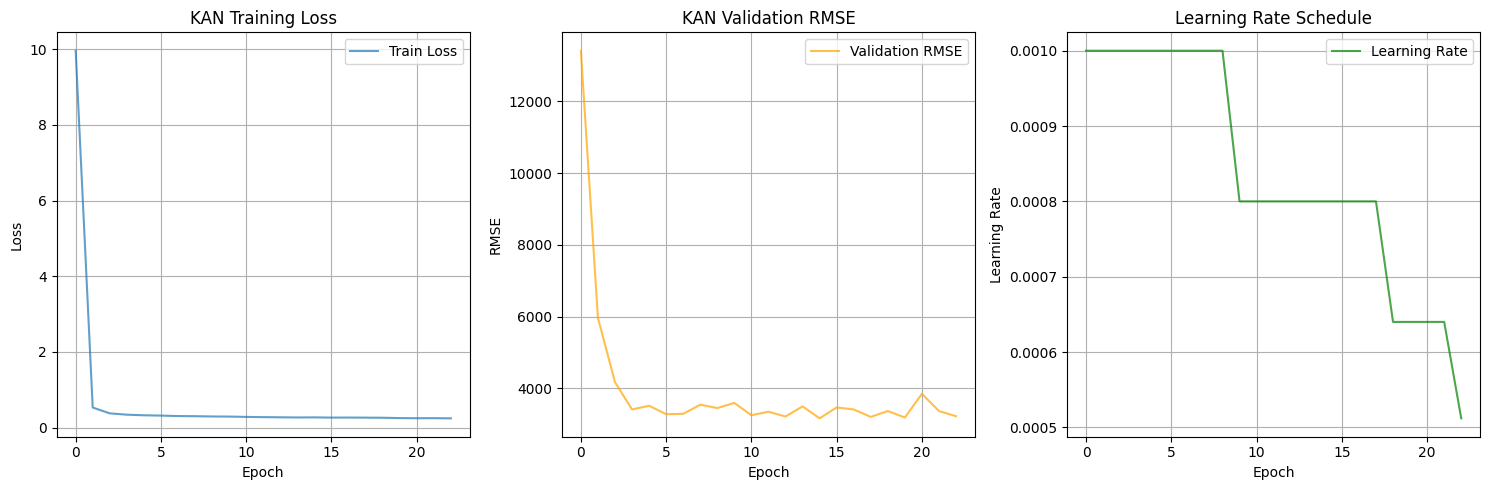


Saved simplified KAN model with 10,129 parameters
Training completed in 23 epochs (1758.3 seconds)
Best validation RMSE: 3160.89

Extracting KAN spline functions for top features...


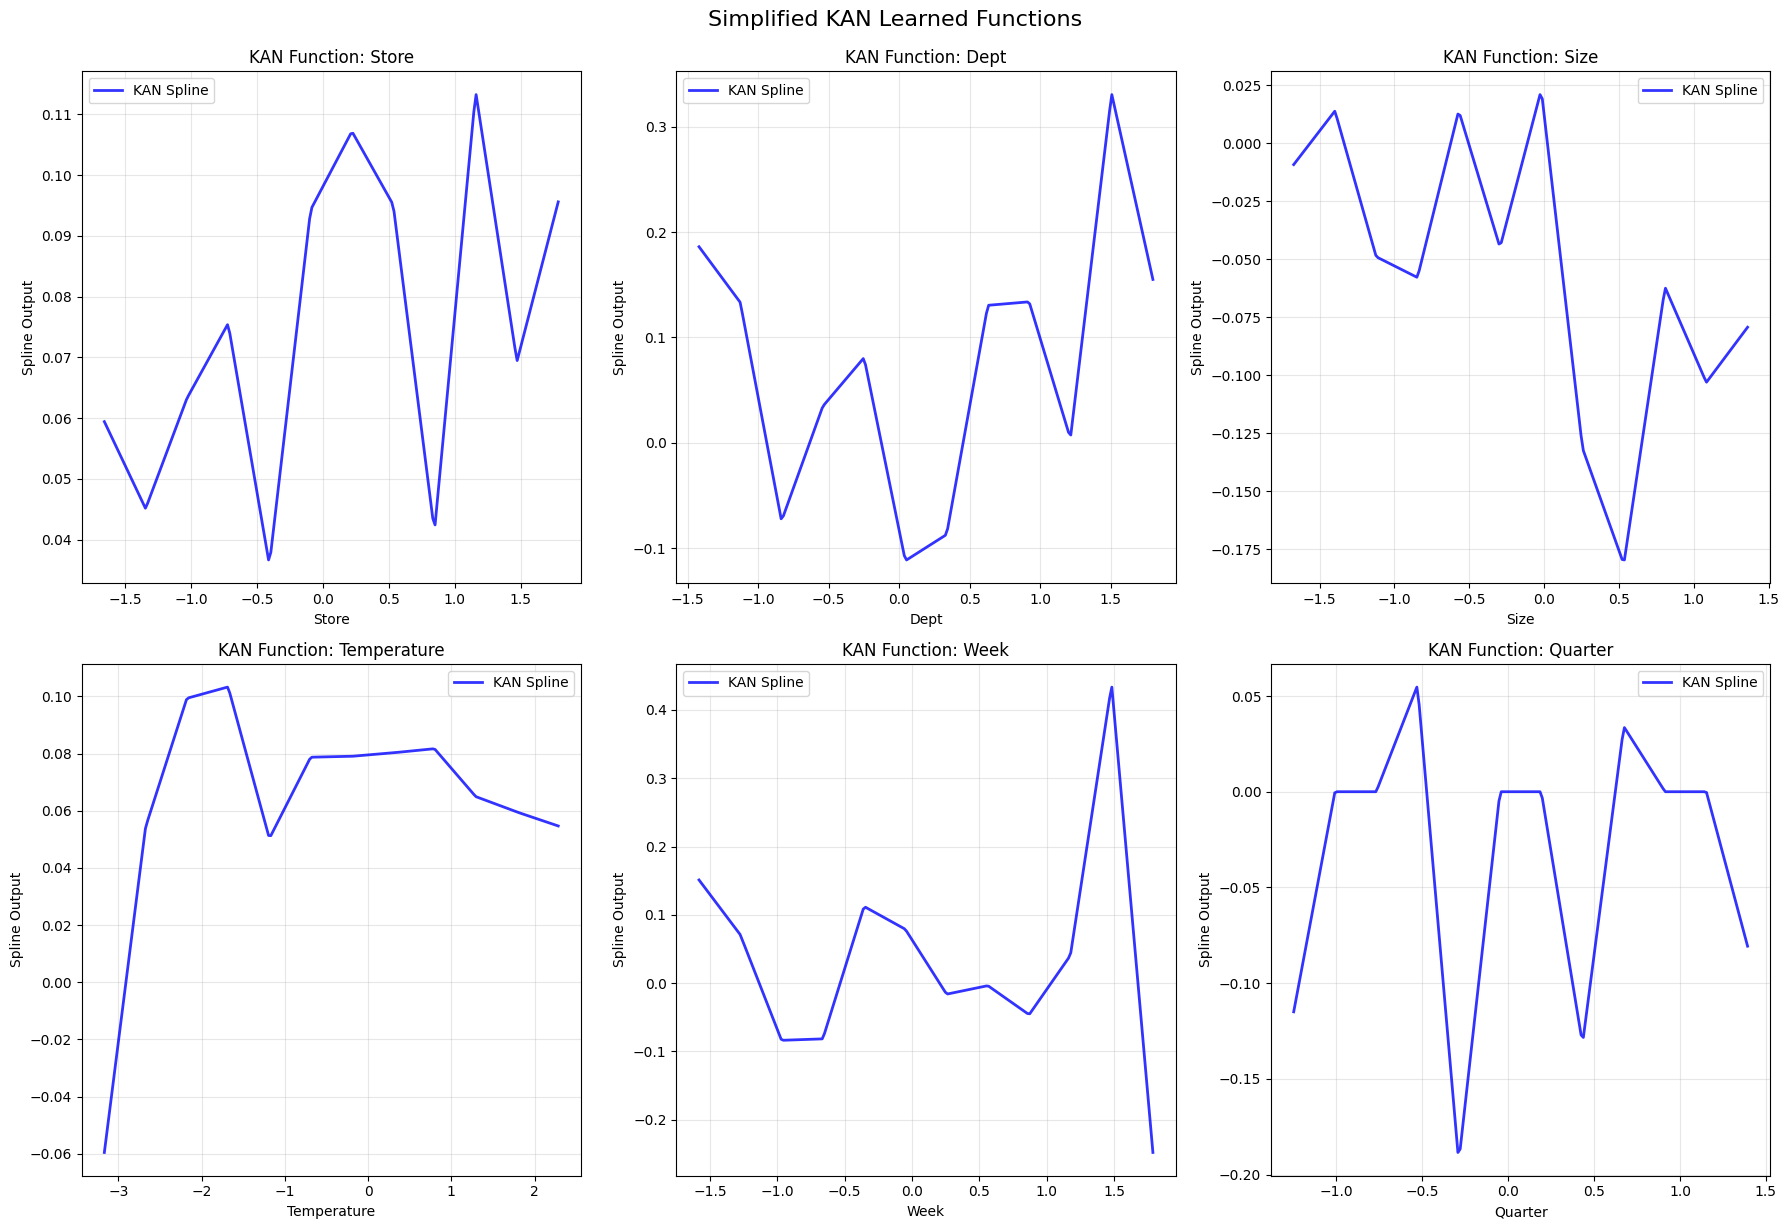

In [15]:
# Fast training loop for simplified KAN
best_rmse = float('inf'); patience = 8; wait = 0; best_state = None
train_losses = []; valid_rmses = []; learning_rates = []
EPOCHS = 30; max_grad_norm = 1.0  # Reduced epochs for faster training

print("Starting simplified KAN training (optimized for CPU)...")
print(f"Training for max {EPOCHS} epochs with patience {patience}")

import time
start_time = time.time()

for epoch in range(1, EPOCHS+1):
    epoch_start = time.time()
    model.train()
    total_loss = 0.0
    
    for batch_idx, (xb, yb) in enumerate(train_loader):
        xb = xb.to(device); yb = yb.to(device)
        optimizer.zero_grad()
        
        out = model(xb)
        loss = criterion(out, yb)
        
        # Minimal regularization
        l2_reg = 0.0
        for name, param in model.named_parameters():
            if 'coeffs' in name:
                l2_reg += torch.norm(param, 2)
        
        total_loss_with_reg = loss + 1e-6 * l2_reg
        total_loss_with_reg.backward()
        
        # Light gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        
        total_loss += float(loss.item()) * xb.size(0)
        
        # Print progress every 50 batches
        if batch_idx % 50 == 0:
            print(f"  Epoch {epoch}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}")
    
    train_loss = total_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation evaluation
    metrics_v, preds_v, y_v = evaluate_model(model, valid_loader, device=device, inv_transform=lambda x: np.expm1(x))
    valid_rmses.append(metrics_v['rmse'])
    
    # Learning rate scheduling
    scheduler.step(metrics_v['rmse'])
    
    # Track learning rate
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)
    
    epoch_time = time.time() - epoch_start
    total_time = time.time() - start_time
    
    print(f"Epoch {epoch:03d} | train_loss={train_loss:.6f} | valid_RMSE={metrics_v['rmse']:.2f} | MAE={metrics_v['mae']:.2f} | R2={metrics_v['r2']:.4f} | LR={current_lr:.2e} | Time: {epoch_time:.1f}s")
    
    # Early stopping with best model saving
    if metrics_v['rmse'] < best_rmse - 1e-4:
        best_rmse = metrics_v['rmse']
        wait = 0
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}
        best_preds_v = preds_v.copy() if len(preds_v) > 0 else np.array([])
        best_y_v = y_v.copy() if len(y_v) > 0 else np.array([])
        print(f"  → New best RMSE: {best_rmse:.2f}")
    else:
        wait += 1
        if wait >= patience:
            print(f'Early stopping at epoch {epoch}')
            break
    
    # Stop if taking too long per epoch
    if epoch_time > 300:  # 5 minutes per epoch is too slow
        print(f'Stopping due to slow training: {epoch_time:.1f}s per epoch')
        break

print(f"\nTotal training time: {time.time() - start_time:.1f} seconds")

# Restore best model and evaluate
if best_state is not None:
    model.load_state_dict(best_state)
    print("Restored best model state")
else:
    print("No best state found, using final model")
    best_state = {k: v.cpu() for k, v in model.state_dict().items()}

val_metrics, preds_v, y_v = evaluate_model(model, valid_loader, device=device, inv_transform=lambda x: np.expm1(x))
test_metrics, preds_t, y_t = evaluate_model(model, test_loader, device=device, inv_transform=lambda x: np.expm1(x))
print('Best valid metrics:', val_metrics)
print('Test metrics:', test_metrics)

# Save artifacts with improved metadata
import json, pandas as pd, torch as _torch
import matplotlib.pyplot as plt

_model_path = MODELS / 'simplified_kan_model.pt'
_report = REPORTS / 'kan_metrics.json'
_preds_val = REPORTS / 'kan_valid_predictions.csv'
_preds_test = REPORTS / 'kan_test_predictions.csv'

# Save predictions
if len(preds_v) > 0 and len(y_v) > 0:
    pd.DataFrame({'y_true': y_v, 'y_pred': preds_v}).to_csv(_preds_val, index=False)
if len(preds_t) > 0 and len(y_t) > 0:
    pd.DataFrame({'y_true': y_t, 'y_pred': preds_t}).to_csv(_preds_test, index=False)

# Save model
_torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': {
        'input_dim': in_features,
        'hidden_dims': [64, 32],
        'n_knots': 12,
        'model_type': 'simplified_kan'
    },
    'training_history': {
        'train_losses': train_losses,
        'valid_rmses': valid_rmses,
        'learning_rates': learning_rates,
        'best_epoch': len(train_losses) - wait if wait < len(train_losses) else len(train_losses),
        'total_training_time': time.time() - start_time
    }
}, _model_path)

# Enhanced metrics with training info
enhanced_metrics = {
    'valid': val_metrics, 
    'test': test_metrics,
    'model_type': 'simplified_kan',
    'architecture': 'Fast spline KAN with linear interpolation',
    'n_parameters': sum(p.numel() for p in model.parameters()),
    'training_epochs': len(train_losses),
    'best_epoch': len(train_losses) - wait if wait < len(train_losses) else len(train_losses),
    'final_lr': learning_rates[-1] if learning_rates else None,
    'training_time_seconds': time.time() - start_time
}

json.dump(enhanced_metrics, open(_report, 'w'), indent=2)

# Plot training curves
if len(train_losses) > 1:
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss', alpha=0.7)
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('KAN Training Loss'); plt.legend(); plt.grid(True)
    
    plt.subplot(1, 3, 2)
    plt.plot(valid_rmses, label='Validation RMSE', color='orange', alpha=0.7)
    plt.xlabel('Epoch'); plt.ylabel('RMSE'); plt.title('KAN Validation RMSE'); plt.legend(); plt.grid(True)
    
    plt.subplot(1, 3, 3)
    plt.plot(learning_rates, label='Learning Rate', color='green', alpha=0.7)
    plt.xlabel('Epoch'); plt.ylabel('Learning Rate'); plt.title('Learning Rate Schedule'); plt.legend(); plt.grid(True)
    
    plt.tight_layout()
    plt.show()

print(f'\nSaved simplified KAN model with {enhanced_metrics["n_parameters"]:,} parameters')
print(f'Training completed in {len(train_losses)} epochs ({enhanced_metrics["training_time_seconds"]:.1f} seconds)')
print(f'Best validation RMSE: {best_rmse:.2f}')

# Extract and visualize some spline functions
print("\nExtracting KAN spline functions for top features...")
feature_names = [c for c in train_df.columns if c != 'Weekly_Sales']
top_features = ['Store', 'Dept', 'Size', 'Temperature', 'Week', 'Quarter']

plt.figure(figsize=(18, 12))
for i, feat_name in enumerate(top_features[:6]):
    if feat_name in feature_names:
        feat_idx = feature_names.index(feat_name)
        x_vals, y_vals = model.get_spline_functions(layer_idx=0, feature_idx=feat_idx, n_points=200)
        
        if x_vals is not None and y_vals is not None:
            plt.subplot(2, 3, i+1)
            plt.plot(x_vals, y_vals, 'b-', linewidth=2, alpha=0.8, label='KAN Spline')
            plt.xlabel(feat_name)
            plt.ylabel('Spline Output')
            plt.title(f'KAN Function: {feat_name}')
            plt.grid(True, alpha=0.3)
            plt.legend()

plt.tight_layout()
plt.suptitle('Simplified KAN Learned Functions', y=1.02, fontsize=16)
plt.show()